# **Tarea - Análisis de Sentimiento Financiero**

[Victor Sanchez](https://github.com/VicoSan07) <br>
Data: [Finviz](https://finviz.com/)

El presente documento tiene como objetivo facilitar el estudio de activos financieros mediante el análisis de sentimientos:

Como preambulo, un **activo financiero** es un bien o derecho que se concreta de una inversión o producto financiero, susceptible de generar una rentabilidad como consecuencia de la captación o utilización de capitales ajenos (RAE, sf). 

La relevancia y uso de este tipo de instrumentos se ha ido acrecentado con el paso de los años.
Hoy en día, el proceso de adquisición de activos se ha simplificado enormemente, de manera que cada persona pueda diseñar su propio portafolio de inversión. Para ello se recomienda (es necesario) contar con conocimientos financieros, así como una actualización y comprensión constante de lo que sucede alrededor del mundo en sus diferentes ramos.

Tal actualización la podemos conseguir mediante la lectura de noticias, pero conforme el mismo número de ellas comienza a crecer, es complicado dar un seguimiento puntual y uniforme. Es justo aquí donde entra en escena el "**Análisis de Sentimientos**", la cuál a grandes rasgos, es una tarea de clasificación masiva de documentos basado en el lenguaje ocupado por los mismos. 

Partiendo de la premisa anterior, se extraerán las noticias más recientes de nuestros activos de intéres mediante la página de Finviz, para posteriormente aplicar un análisis de sentimientos sobre estos, y generar conclusiones al respecto.

In [ ]:
# Librerias

# Nos permite conectar con páginas de internet
from urllib.request import urlopen, Request
# Nos permite analizar documentos HTML
from bs4 import BeautifulSoup

# Para manejo de dataframes y visualización de datos
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Para análisis de sentimientos
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Bajo el supuesto de analizar 6 emisoras de distintos sectores, consideremos las siguientes:

* [NVIDIA](https://www.nvidia.com/en-us/)
* [Walmart](https://walmart.com/)
* [Jhonson & Jhonson](https://www.jnj.com/)
* [Amazon](https://www.amazon.com/)
* [General Electric](https://www.ge.com/)
* [Google](https://www.google.com/)

En esta primera parte se extraera toda la información correspondiente a las noticias de la página para cada emisora, mismas que se encuentran en el id *'news_table'*

In [90]:
#Tickers de identificación
tickers = ['NVDA', 'WMT', 'JNJ','AMZN','GE','GOOGL']

In [91]:
#Extracción de noticias

search_url = 'https://finviz.com/quote.ashx?t=' #url de busqueda
news_tables = {} #colección de noticias

for ticker in tickers:
    url = search_url + ticker
    req = Request(url=url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table') #ver código fuente de la página
    news_tables[ticker] = news_table

Continuando con el código, se estructuran las noticias por ticker, fecha, hora y texto; y se depositarán en un dataframe

In [167]:
#Dataframe de noticias
structured_news = []

for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.get_text() #solo nos regrese el texto
        date_scrape = x.td.text.split() #solo la fecha

        #solo la hora
        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0] #solo el ticket
        
        structured_news.append([ticker, date, time, text])

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(structured_news, columns=columns)
news.head()

,Ticker,Date,Time,Headline
0,NVDA,Jun-07-23,07:49PM,Jun-07-23 07:49PMLooking Ahead to the Q2 Earni...
1,NVDA,Jun-07-23,05:32PM,05:32PMBillionaire NVIDIA CEO Jensen Huang Tel...
2,NVDA,Jun-07-23,05:30PM,05:30PMNasdaq Skids But These Areas Run; Meme ...
3,NVDA,Jun-07-23,04:59PM,04:59PM7 Companies Are Dominating the Stock Ma...
4,NVDA,Jun-07-23,04:28PM,04:28PMBest Stocks to Buy Now: My 10 Top Semic...


En la columna *Headline* podemos observar un par de detalles:

* La hora se encuentra pegada junto al títular de la noticia
* Al final de cada noticia, aparece la página de origen

Estos dos issues los atenderemos a continuación

In [168]:
#Permite modificar cadenas de texto
import re

#Extrayendo website
def Modtexton(text):
    text = re.findall(r'\((.*?)\)',text)
    return text

#Removiendo website
def Modtextoff(text):
    text = re.sub("[\(\[].*?[\)\]]", "", text)
    return text

news["Website"] = news["Headline"].apply(Modtexton)
news["Headline"] = news["Headline"].apply(Modtextoff)

#Removiendo hora
news['Headline'] = news.apply(lambda row : row['Headline'].replace(str(row['Time']), ''), axis=1)
news.head()

,Ticker,Date,Time,Headline,Website
0,NVDA,Jun-07-23,07:49PM,Jun-07-23 Looking Ahead to the Q2 Earnings Season,[Zacks]
1,NVDA,Jun-07-23,05:32PM,Billionaire NVIDIA CEO Jensen Huang Tells Grad...,[Benzinga]
2,NVDA,Jun-07-23,05:30PM,Nasdaq Skids But These Areas Run; Meme Stock G...,[Investor's Business Daily]
3,NVDA,Jun-07-23,04:59PM,7 Companies Are Dominating the Stock Market. M...,[Barrons.com]
4,NVDA,Jun-07-23,04:28PM,Best Stocks to Buy Now: My 10 Top Semiconducto...,[Motley Fool]


Una vez lista nuestra base, procedemos a realizar el análisis de sentimientos utilizando VADER

In [169]:
#Análisis de Sentimientos
analyzer = SentimentIntensityAnalyzer()
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()
df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')
news.head()

,Ticker,Date,Time,Headline,Website,neg,neu,pos,compound
0,NVDA,Jun-07-23,07:49PM,Jun-07-23 Looking Ahead to the Q2 Earnings Season,[Zacks],0.000,1.000,0.000,0.0000
1,NVDA,Jun-07-23,05:32PM,Billionaire NVIDIA CEO Jensen Huang Tells Grad...,[Benzinga],0.000,0.692,0.308,0.5994
2,NVDA,Jun-07-23,05:30PM,Nasdaq Skids But These Areas Run; Meme Stock G...,[Investor's Business Daily],0.000,1.000,0.000,0.0000
3,NVDA,Jun-07-23,04:59PM,7 Companies Are Dominating the Stock Market. M...,[Barrons.com],0.196,0.804,0.000,-0.2960
4,NVDA,Jun-07-23,04:28PM,Best Stocks to Buy Now: My 10 Top Semiconducto...,[Motley Fool],0.000,0.647,0.353,0.7184


In [227]:
#Añadimos una nueva columna que clasifique la noticia en función de la clase dominante
news['type']=''
news.loc[news.compound>0,'type']='Positive'
news.loc[news.compound==0,'type']='Neutral'
news.loc[news.compound<0,'type']='Negative'
news.head()

,Ticker,Date,Time,Headline,Website,neg,neu,pos,compound,type
0,NVDA,2023-06-07,07:49PM,Jun-07-23 Looking Ahead to the Q2 Earnings Season,[Zacks],0.000,1.000,0.000,0.0000,Neutral
1,NVDA,2023-06-07,05:32PM,Billionaire NVIDIA CEO Jensen Huang Tells Grad...,[Benzinga],0.000,0.692,0.308,0.5994,Positive
2,NVDA,2023-06-07,05:30PM,Nasdaq Skids But These Areas Run; Meme Stock G...,[Investor's Business Daily],0.000,1.000,0.000,0.0000,Neutral
3,NVDA,2023-06-07,04:59PM,7 Companies Are Dominating the Stock Market. M...,[Barrons.com],0.196,0.804,0.000,-0.2960,Negative
4,NVDA,2023-06-07,04:28PM,Best Stocks to Buy Now: My 10 Top Semiconducto...,[Motley Fool],0.000,0.647,0.353,0.7184,Positive


In [261]:
#Definimos una nueva columna de Mes y Año
news['Date'] = pd.to_datetime(news.Date, format='%Y-%m-%d')
news['Periodo'] = news['Date'].dt.to_period('M')

In [241]:
#Creamos un dataframe que agrupe la clase de las noticias por emisora y periodo
df_websites = news.groupby(['Ticker','Periodo','type'], as_index=False).size()
df_websites.columns = ['Ticker','Periodo','Clase','Total']

In [243]:
#Imprimimos treemap
import plotly.express as px
  
fig = px.treemap(df_websites, path=['Ticker','Clase','Periodo'],
                 values='Total',
                 color='Total')
 
fig.show()

In [ ]:
#Calculamos ponderación promedia de las noticias de cada emisor
df_rating = pd.DataFrame(news.groupby(['Ticker'], as_index=False)['compound'].mean())
df_rating.columns = ['Ticker','Rating']
#ss2 = ss.pivot(index='Date', columns='Ticker')
#ss3 = ss2['Rating'].reset_index()
#ss3.columns.name = None
#ss3

In [247]:
#Gráfico de barras
import plotly.express as px

fig_1 = px.bar(ss, x = 'Ticker', y = 'Rating',
             color = 'Rating')
fig_1.update_traces(marker_line_color = 'black',
                  marker_line_width = 2, opacity = 1)
fig_1.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)'
})
fig_1.update_xaxes(visible=True, showticklabels=True)

fig_1.show()

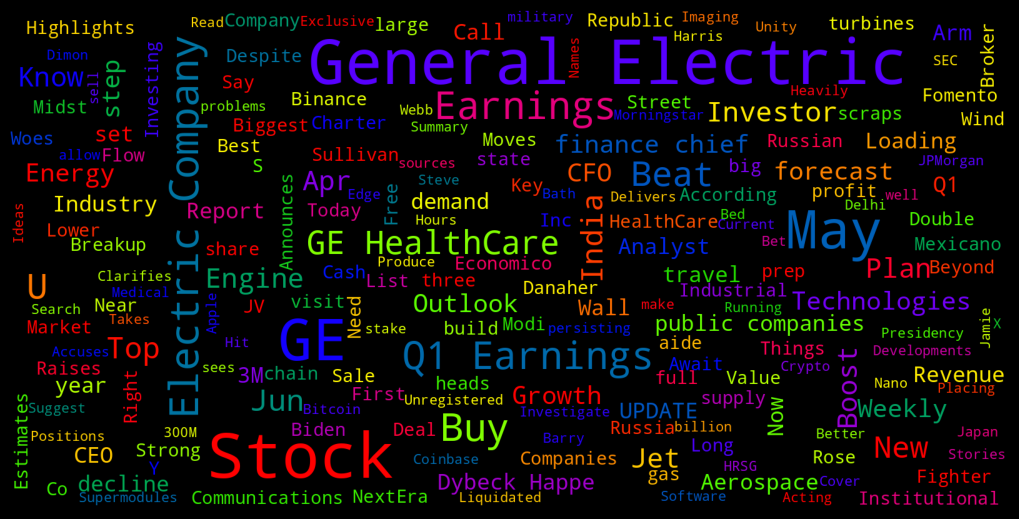

In [253]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([twts for twts in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=100,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(10,5), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

word_cloud(news.loc[news['Ticker']=='GE','Headline'])

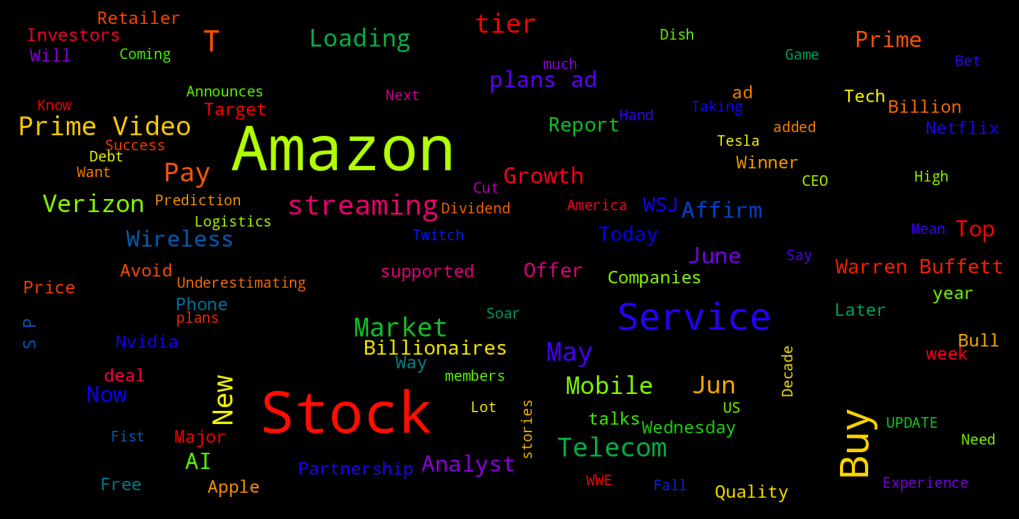

In [254]:
word_cloud(news.loc[news['Ticker']=='AMZN','Headline'])

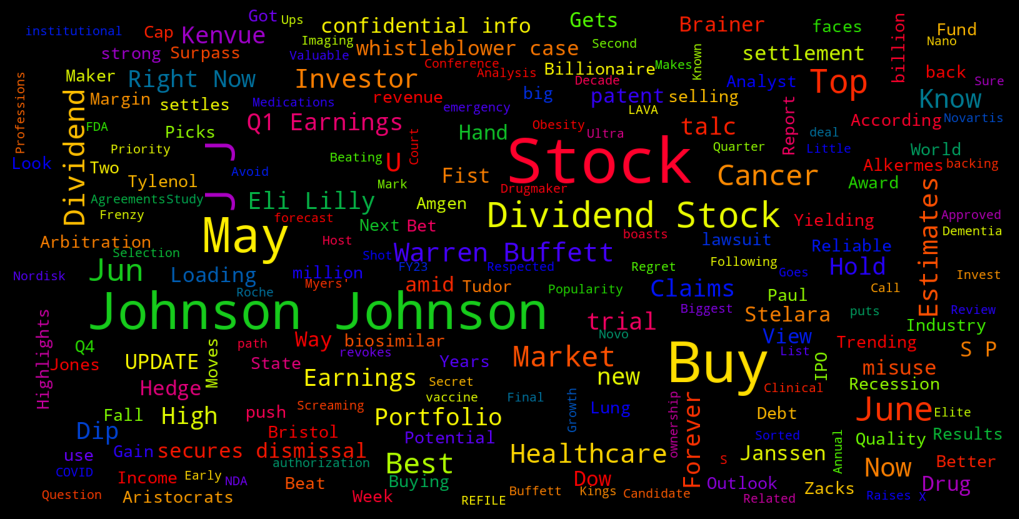

In [256]:
word_cloud(news.loc[news['Ticker']=='JNJ','Headline'])